<a href="https://colab.research.google.com/github/Sarthakcodes007/Sarthakcodes007/blob/main/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd

X = pd.read_csv('/content/engineered_freight_data_phase1.csv')

In [6]:
import numpy as np

# List of duration columns
duration_cols = [
    'Time_Placing', 'Time_Loading', 'Time_Dispatching',
    'Time_Unload_Placing', 'Time_Unloading', 'Time_Unload_Dispatch'
]

# Replace 0 or negative durations with NaN
for col in duration_cols:
    X[col] = X[col].apply(lambda x: x if x > 0 else np.nan)

# Check how many invalids were removed
X[duration_cols].isna().sum()


Time_Placing            1131
Time_Loading               0
Time_Dispatching         278
Time_Unload_Placing     1709
Time_Unloading             0
Time_Unload_Dispatch     242
dtype: int64

In [7]:
# Clip values above 99th percentile
for col in duration_cols:
    upper_limit = X[col].quantile(0.99)
    X[col] = np.clip(X[col], None, upper_limit)

# Preview cleaned stats
X[duration_cols].describe()


Time_Placing  Time_Loading  Time_Dispatching  Time_Unload_Placing  \
count   8869.000000   10000.00000       9722.000000          8291.000000   
mean     161.721682     270.56260        317.117751            83.629417   
std      261.329777     245.27351        457.247204           138.708293   
min        1.000000       1.00000          1.000000             1.000000   
25%       30.000000     135.00000         72.000000            15.000000   
50%       75.000000     200.00000        161.000000            40.000000   
75%      165.000000     310.00000        365.000000            90.000000   
max     1681.400000    1605.00000       2873.110000           930.500000   

       Time_Unloading  Time_Unload_Dispatch  
count    10000.000000           9758.000000  
mean       426.353000            250.499867  
std        330.934054            344.257691  
min          1.000000              1.000000  
25%        215.000000             64.000000  
50%        355.000000            137.000000  
75%        530.000000            280.000000  
max       1920.050000           2197.150000

In [8]:
from sklearn.preprocessing import LabelEncoder

# List of categorical columns
cat_cols = [
    'From Station', 'Division', 'Zone', 'Section',
    'Type', 'Rake Type', 'Commodity', 'Unloading Sttn',
    'To Zone', 'Section To'
]

# Initialize encoder
le = LabelEncoder()

# Apply label encoding to each column
for col in cat_cols:
    X[col] = X[col].astype(str)  # Ensure string type
    X[col] = le.fit_transform(X[col])


In [9]:
# Fast if loading time < 120 mins, unloading < 150 mins (adjustable thresholds)
X['Fast_Loading'] = X['Time_Loading'].apply(lambda x: 1 if x < 120 else 0 if pd.notna(x) else np.nan)
X['Fast_Unloading'] = X['Time_Unloading'].apply(lambda x: 1 if x < 150 else 0 if pd.notna(x) else np.nan)


In [10]:
# Consider all 3 steps taking longer than 3 hours (180 mins)
X['All_Steps_Slow'] = (
    (X['Time_Placing'] > 180) &
    (X['Time_Loading'] > 180) &
    (X['Time_Dispatching'] > 180)
).astype(int)


In [11]:
# Parse datetime again if needed
X['Arrival_Hour'] = pd.to_datetime(X['Arrival Time'], dayfirst=True, errors='coerce').dt.hour
X['Is_Night_Arrival'] = X['Arrival_Hour'].apply(lambda x: 1 if x < 6 or x >= 20 else 0)


In [12]:
# Features we'll use (feel free to add more if needed)
features = [
    'From Station', 'Division', 'Zone', 'Section', 'Type', 'Rake Type',
    'Commodity', 'Unloading Sttn', 'To Zone', 'Section To',
    'Fast_Loading', 'All_Steps_Slow', 'Arrival_Hour', 'Is_Night_Arrival',
    'Time_Placing'  # past duration info as a feature
]

target = 'Time_Loading'


In [13]:
from sklearn.model_selection import train_test_split

# Drop rows with missing target or feature values
X_model = X[features + [target]].dropna()

X_train, X_test, y_train, y_test = train_test_split(
    X_model[features], X_model[target], test_size=0.2, random_state=42
)


In [14]:
import lightgbm as lgb
from sklearn.metrics import r2_score

# Train model
model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("🔍 R² Score (Accuracy):", r2)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1373
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 15
[LightGBM] [Info] Start training from score 284.437500
🔍 R² Score (Accuracy): 0.518191342009741


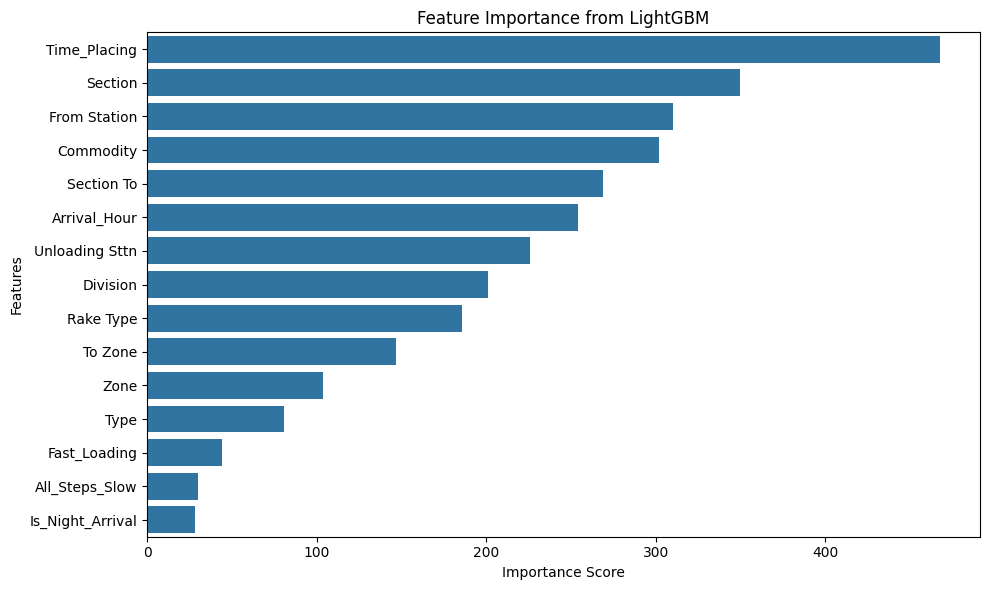

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot feature importance
feature_imp = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.title("Feature Importance from LightGBM")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


In [16]:
# Average loading time per station
station_avg_loading = X.groupby('From Station')['Time_Loading'].mean().to_dict()
X['Station_Loading_Avg'] = X['From Station'].map(station_avg_loading)


In [17]:
# Day of Week and Month
X['Arrival_Date'] = pd.to_datetime(X['Arrival Time'], dayfirst=True, errors='coerce')
X['Arrival_Weekday'] = X['Arrival_Date'].dt.weekday
X['Arrival_Month'] = X['Arrival_Date'].dt.month


In [18]:
model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)


In [19]:
# Mean and count of loading time per 'From Station'
station_stats = X.groupby('From Station')['Time_Loading'].agg(['mean', 'count']).reset_index()
station_stats.columns = ['From Station', 'Station_Loading_Avg', 'Station_Loading_Count']

# Merge into original X
X = X.merge(station_stats, on='From Station', how='left')


In [20]:
# Calculate slow rate = % of times Time_Loading > 180 mins
X['Slow_Load_Flag'] = X['Time_Loading'].apply(lambda x: 1 if x > 180 else 0)
slow_rate = X.groupby('From Station')['Slow_Load_Flag'].mean().reset_index()
slow_rate.columns = ['From Station', 'Station_Slow_Load_Rate']

X = X.merge(slow_rate, on='From Station', how='left')


In [21]:
# Ensure Arrival is datetime
X['Arrival_Date'] = pd.to_datetime(X['Arrival Time'], dayfirst=True, errors='coerce')

# Add day of week and month
X['Arrival_Weekday'] = X['Arrival_Date'].dt.weekday
X['Arrival_Month'] = X['Arrival_Date'].dt.month


In [22]:
features = [
    'Zone', 'Division', 'Type', 'Rake Type', 'Commodity', 'To Zone', 'Section',
    'Fast_Loading', 'All_Steps_Slow', 'Arrival_Hour', 'Is_Night_Arrival',
    'Time_Placing', 'Station_Loading_Avg', 'Station_Loading_Count',
    'Station_Slow_Load_Rate', 'Arrival_Weekday', 'Arrival_Month'
]


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import lightgbm as lgb

X_model = X[features + ['Time_Loading']].dropna()

X_train, X_test, y_train, y_test = train_test_split(
    X_model[features], X_model['Time_Loading'], test_size=0.2, random_state=42
)

model = lgb.LGBMRegressor(
    n_estimators=500, learning_rate=0.03, max_depth=10,
    subsample=0.8, colsample_bytree=0.8, random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("🔁 Updated R² Score (Accuracy):", r2)


KeyError: "['Station_Loading_Avg'] not in index"

In [24]:
# Step 1: Check column name
print(X.columns)

# If 'Time_Loading' exists, proceed
station_stats = X.groupby('From Station')['Time_Loading'].agg(['mean', 'count']).reset_index()
station_stats.columns = ['From Station', 'Station_Loading_Avg', 'Station_Loading_Count']


Index(['Month', 'Rakeid', 'Loadid', 'From Station', 'Name', 'Division', 'Zone',
       'Section', 'Arrival Time', 'Placement Time', 'Rels Time', 'Depart Time',
       'destination', 'Name.1', 'Division.1', 'To Zone', 'Section To', 'Type',
       'Rake Type', 'Commodity', 'Actl Weight', 'Chargeable Wght', 'Avg Units',
       'Km', 'Avg Time', 'Speed', 'Unloading Sttn', 'Arrival Time.1',
       'Placement Time.1', 'Rels Time.1', 'Depart Time.1', 'Time_Placing',
       'Time_Loading', 'Time_Dispatching', 'Time_Unload_Placing',
       'Time_Unloading', 'Time_Unload_Dispatch', 'Fast_Loading',
       'Fast_Unloading', 'All_Steps_Slow', 'Arrival_Hour', 'Is_Night_Arrival',
       'Station_Loading_Avg_x', 'Arrival_Date', 'Arrival_Weekday',
       'Arrival_Month', 'Station_Loading_Avg_y', 'Station_Loading_Count',
       'Slow_Load_Flag', 'Station_Slow_Load_Rate'],
      dtype='object')


In [25]:
X = X.merge(station_stats, on='From Station', how='left')


In [26]:
X['Slow_Load_Flag'] = X['Time_Loading'].apply(lambda x: 1 if x > 180 else 0)

slow_rate = X.groupby('From Station')['Slow_Load_Flag'].mean().reset_index()
slow_rate.columns = ['From Station', 'Station_Slow_Load_Rate']

X = X.merge(slow_rate, on='From Station', how='left')


In [27]:
X_model = X[features + ['Time_Loading']].dropna()

X_train, X_test, y_train, y_test = train_test_split(
    X_model[features], X_model['Time_Loading'], test_size=0.2, random_state=42
)

model = lgb.LGBMRegressor(
    n_estimators=500, learning_rate=0.03, max_depth=10,
    subsample=0.8, colsample_bytree=0.8, random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("🔁 Updated R² Score (Accuracy):", r2)


KeyError: "['Station_Loading_Count', 'Station_Slow_Load_Rate'] not in index"

In [28]:
# Step 1: Calculate average and count of Time_Loading per station
station_stats = X.groupby('From Station')['Time_Loading'].agg(['mean', 'count']).reset_index()
station_stats.columns = ['From Station', 'Station_Loading_Avg', 'Station_Loading_Count']

# Step 2: Merge these stats back to your dataset
X = X.merge(station_stats, on='From Station', how='left')

# Step 3: Create a binary flag for slow loading (e.g., more than 3 hours)
X['Slow_Load_Flag'] = X['Time_Loading'].apply(lambda x: 1 if x > 180 else 0)

# Step 4: Calculate slow load rate per station
slow_rate = X.groupby('From Station')['Slow_Load_Flag'].mean().reset_index()
slow_rate.columns = ['From Station', 'Station_Slow_Load_Rate']

# Step 5: Merge slow load rate to the dataset
X = X.merge(slow_rate, on='From Station', how='left')


MergeError: Passing 'suffixes' which cause duplicate columns {'Station_Loading_Avg_x'} is not allowed.

In [29]:
# Drop if already present to avoid MergeError
X = X.drop(columns=[
    'Station_Loading_Avg',
    'Station_Loading_Count',
    'Station_Slow_Load_Rate',
    'Slow_Load_Flag'
], errors='ignore')  # errors='ignore' avoids crash if a column is missing

# Step 1: Calculate average and count of Time_Loading per station
station_stats = X.groupby('From Station')['Time_Loading'].agg(['mean', 'count']).reset_index()
station_stats.columns = ['From Station', 'Station_Loading_Avg', 'Station_Loading_Count']

# Step 2: Merge these stats back into X
X = X.merge(station_stats, on='From Station', how='left')

# Step 3: Create a binary flag for slow loading (e.g., > 180 minutes)
X['Slow_Load_Flag'] = X['Time_Loading'].apply(lambda x: 1 if x > 180 else 0)

# Step 4: Calculate slow load rate per station
slow_rate = X.groupby('From Station')['Slow_Load_Flag'].mean().reset_index()
slow_rate.columns = ['From Station', 'Station_Slow_Load_Rate']

# Step 5: Merge slow rate back into X
X = X.merge(slow_rate, on='From Station', how='left')


In [30]:
X_model = X[features + ['Time_Loading']].dropna()

X_train, X_test, y_train, y_test = train_test_split(
    X_model[features], X_model['Time_Loading'], test_size=0.2, random_state=42
)

model = lgb.LGBMRegressor(
    n_estimators=500, learning_rate=0.03, max_depth=10,
    subsample=0.8, colsample_bytree=0.8, random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("🔁 Updated R² Score (Accuracy):", r2)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1148
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 17
[LightGBM] [Info] Start training from score 284.437500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

In [31]:
from sklearn.model_selection import cross_val_score, KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    model,
    X_model[features],
    X_model['Time_Loading'],
    scoring='r2',
    cv=kf,
    n_jobs=-1
)
print("CV R² scores:", cv_scores)
print("Mean CV R²:", cv_scores.mean())


CV R² scores: [0.72886788 0.71326795 0.67612192 0.73188712 0.64467447]
Mean CV R²: 0.6989638660057402


In [32]:
import optuna

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42
    }
    model_tune = lgb.LGBMRegressor(**params)
    score = cross_val_score(model_tune, X_model[features], X_model['Time_Loading'], scoring='r2', cv=5).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best parameters:", study.best_params)
print("Best CV R²:", study.best_value)


ModuleNotFoundError: No module named 'optuna'

In [33]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 11.6 MB/s eta 0:00:00


In [34]:
import optuna

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42
    }
    model_tune = lgb.LGBMRegressor(**params)
    score = cross_val_score(model_tune, X_model[features], X_model['Time_Loading'], scoring='r2', cv=5).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best parameters:", study.best_params)
print("Best CV R²:", study.best_value)


[I 2025-06-09 18:25:43,227] A new study created in memory with name: no-name-4e03b29b-9afe-453c-b25e-b40b9a913a46


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 17
[LightGBM] [Info] Start training from score 268.116319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-06-09 18:25:50,244] Trial 0 finished with value: 0.5963035766849107 and parameters: {'n_estimators': 516, 'learning_rate': 0.11023398408871281, 'max_depth': 8, 'subsample': 0.5265367581569393, 'colsample_bytree': 0.9504834212787104}. Best is trial 0 with value: 0.5963035766849107.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 17
[LightGBM] [Info] Start training from score 268.116319
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1157
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 17
[LightGBM] [Info] Start training from score 293.617708
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM]

[I 2025-06-09 18:25:52,507] Trial 1 finished with value: 0.644728831485734 and parameters: {'n_estimators': 210, 'learning_rate': 0.009562057403789032, 'max_depth': 9, 'subsample': 0.694876073881523, 'colsample_bytree': 0.7503081831047402}. Best is trial 1 with value: 0.644728831485734.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 17
[LightGBM] [Info] Start training from score 268.116319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-06-09 18:25:55,360] Trial 2 finished with value: 0.6367346369273581 and parameters: {'n_estimators': 467, 'learning_rate': 0.041964995033161985, 'max_depth': 12, 'subsample': 0.7305377136869127, 'colsample_bytree': 0.5270577105107207}. Best is trial 1 with value: 0.644728831485734.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 17
[LightGBM] [Info] Start training from score 268.116319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-06-09 18:25:58,953] Trial 3 finished with value: 0.6467806433602916 and parameters: {'n_estimators': 736, 'learning_rate': 0.03371441915159971, 'max_depth': 5, 'subsample': 0.6836051063746578, 'colsample_bytree': 0.939666712418542}. Best is trial 3 with value: 0.6467806433602916.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-09 18:26:03,930] Trial 4 finished with value: 0.5799395907674045 and parameters: {'n_estimators': 807, 'learning_rate': 0.13807825708846236, 'max_depth': 13, 'subsample': 0.9292724167699685, 'colsample_bytree': 0.7830659499118695}. Best is trial 3 with value: 0.6467806433602916.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 17
[LightGBM] [Info] Start training from score 268.116319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-06-09 18:26:05,649] Trial 5 finished with value: 0.6081681916811235 and parameters: {'n_estimators': 372, 'learning_rate': 0.1378020302039243, 'max_depth': 9, 'subsample': 0.8723966599245776, 'colsample_bytree': 0.5857787530854313}. Best is trial 3 with value: 0.6467806433602916.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGB

[I 2025-06-09 18:26:06,165] Trial 6 finished with value: 0.6355770505311029 and parameters: {'n_estimators': 106, 'learning_rate': 0.17211728308633878, 'max_depth': 7, 'subsample': 0.5619938938518451, 'colsample_bytree': 0.732110843978928}. Best is trial 3 with value: 0.6467806433602916.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-09 18:26:06,855] Trial 7 finished with value: 0.6457518322168462 and parameters: {'n_estimators': 293, 'learning_rate': 0.13613345813669772, 'max_depth': 3, 'subsample': 0.7209137099832335, 'colsample_bytree': 0.5136586155865017}. Best is trial 3 with value: 0.6467806433602916.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-09 18:26:13,485] Trial 8 finished with value: 0.6605727837805323 and parameters: {'n_estimators': 850, 'learning_rate': 0.0074646904381935365, 'max_depth': 13, 'subsample': 0.5559961961842237, 'colsample_bytree': 0.7254865083374523}. Best is trial 8 with value: 0.6605727837805323.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 17
[LightGBM] [Info] Start training from score 268.116319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-06-09 18:26:14,548] Trial 9 finished with value: 0.6011561638047604 and parameters: {'n_estimators': 311, 'learning_rate': 0.19462891501476595, 'max_depth': 5, 'subsample': 0.8275320022530024, 'colsample_bytree': 0.7275566788368988}. Best is trial 8 with value: 0.6605727837805323.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1131
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 17
[LightGBM] [Info] Start training from score 260.757639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-06-09 18:26:18,280] Trial 10 finished with value: 0.611748848315728 and parameters: {'n_estimators': 647, 'learning_rate': 0.07141925856552782, 'max_depth': 15, 'subsample': 0.6141890288000353, 'colsample_bytree': 0.8500083082139771}. Best is trial 8 with value: 0.6605727837805323.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 17
[LightGBM] [Info] Start training from score 268.116319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-06-09 18:26:25,128] Trial 11 finished with value: 0.6444311968240403 and parameters: {'n_estimators': 993, 'learning_rate': 0.011819327622273383, 'max_depth': 12, 'subsample': 0.6497024089876552, 'colsample_bytree': 0.9980836002933915}. Best is trial 8 with value: 0.6605727837805323.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 17
[LightGBM] [Info] Start training from score 268.116319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-06-09 18:26:28,169] Trial 12 finished with value: 0.6315690311690706 and parameters: {'n_estimators': 752, 'learning_rate': 0.052890011359325646, 'max_depth': 5, 'subsample': 0.5916601959777442, 'colsample_bytree': 0.6540331949302086}. Best is trial 8 with value: 0.6605727837805323.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-09 18:26:33,702] Trial 13 finished with value: 0.6151565811698093 and parameters: {'n_estimators': 941, 'learning_rate': 0.04113951848256393, 'max_depth': 15, 'subsample': 0.5041627699662454, 'colsample_bytree': 0.8521506369752254}. Best is trial 8 with value: 0.6605727837805323.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 17
[LightGBM] [Info] Start training from score 268.116319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-06-09 18:26:39,613] Trial 14 finished with value: 0.5973299537496053 and parameters: {'n_estimators': 842, 'learning_rate': 0.08740327983498818, 'max_depth': 11, 'subsample': 0.8213515407856221, 'colsample_bytree': 0.8839725221148247}. Best is trial 8 with value: 0.6605727837805323.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 17
[LightGBM] [Info] Start training from score 268.116319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-06-09 18:26:41,839] Trial 15 finished with value: 0.6589895727703565 and parameters: {'n_estimators': 663, 'learning_rate': 0.005381250221334769, 'max_depth': 3, 'subsample': 0.6789023441496607, 'colsample_bytree': 0.6515559603679143}. Best is trial 8 with value: 0.6605727837805323.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-09 18:26:43,252] Trial 16 finished with value: 0.6622262157159696 and parameters: {'n_estimators': 614, 'learning_rate': 0.0074461872895206106, 'max_depth': 3, 'subsample': 0.6316052031655379, 'colsample_bytree': 0.6592534336977249}. Best is trial 16 with value: 0.6622262157159696.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-09 18:26:46,769] Trial 17 finished with value: 0.6168009909120342 and parameters: {'n_estimators': 607, 'learning_rate': 0.06997805829040799, 'max_depth': 11, 'subsample': 0.6187282481795158, 'colsample_bytree': 0.6613317284656444}. Best is trial 16 with value: 0.6622262157159696.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 17
[LightGBM] [Info] Start training from score 268.116319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-06-09 18:26:51,347] Trial 18 finished with value: 0.6452915498635037 and parameters: {'n_estimators': 888, 'learning_rate': 0.023834235064008835, 'max_depth': 7, 'subsample': 0.5701955556725341, 'colsample_bytree': 0.5834466759359319}. Best is trial 16 with value: 0.6622262157159696.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 17
[LightGBM] [Info] Start training from score 268.116319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-06-09 18:26:56,889] Trial 19 finished with value: 0.6196892007337645 and parameters: {'n_estimators': 440, 'learning_rate': 0.06297268066915945, 'max_depth': 14, 'subsample': 0.7868885818106295, 'colsample_bytree': 0.7989202532887671}. Best is trial 16 with value: 0.6622262157159696.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 17
[LightGBM] [Info] Start training from score 268.116319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-06-09 18:27:02,208] Trial 20 finished with value: 0.6135846445714008 and parameters: {'n_estimators': 573, 'learning_rate': 0.0845248287009286, 'max_depth': 10, 'subsample': 0.5438634233350936, 'colsample_bytree': 0.6924052622304674}. Best is trial 16 with value: 0.6622262157159696.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 17
[LightGBM] [Info] Start training from score 268.116319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-06-09 18:27:03,781] Trial 21 finished with value: 0.6621508470925755 and parameters: {'n_estimators': 686, 'learning_rate': 0.007122998249696075, 'max_depth': 3, 'subsample': 0.6605202771349206, 'colsample_bytree': 0.6170255837985618}. Best is trial 16 with value: 0.6622262157159696.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-09 18:27:05,918] Trial 22 finished with value: 0.6572116340479554 and parameters: {'n_estimators': 720, 'learning_rate': 0.02802167013873949, 'max_depth': 4, 'subsample': 0.6414611987723837, 'colsample_bytree': 0.5940252356829673}. Best is trial 16 with value: 0.6622262157159696.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-09 18:27:09,671] Trial 23 finished with value: 0.6480789796447453 and parameters: {'n_estimators': 812, 'learning_rate': 0.021059543595933906, 'max_depth': 6, 'subsample': 0.5822290847083433, 'colsample_bytree': 0.6259290823431481}. Best is trial 16 with value: 0.6622262157159696.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 17
[LightGBM] [Info] Start training from score 268.116319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-06-09 18:27:11,839] Trial 24 finished with value: 0.6557414731102209 and parameters: {'n_estimators': 710, 'learning_rate': 0.0491087841923325, 'max_depth': 3, 'subsample': 0.9811256051945358, 'colsample_bytree': 0.7047091520634222}. Best is trial 16 with value: 0.6622262157159696.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 17
[LightGBM] [Info] Start training from score 268.116319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-06-09 18:27:14,420] Trial 25 finished with value: 0.6570783569352384 and parameters: {'n_estimators': 530, 'learning_rate': 0.005545415430247014, 'max_depth': 4, 'subsample': 0.769185700249993, 'colsample_bytree': 0.5599952719124179}. Best is trial 16 with value: 0.6622262157159696.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-09 18:27:19,784] Trial 26 finished with value: 0.6428504756806429 and parameters: {'n_estimators': 891, 'learning_rate': 0.026912611097144296, 'max_depth': 7, 'subsample': 0.6490429129053381, 'colsample_bytree': 0.6160766844388723}. Best is trial 16 with value: 0.6622262157159696.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 17
[LightGBM] [Info] Start training from score 268.116319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-06-09 18:27:22,909] Trial 27 finished with value: 0.6137020361143243 and parameters: {'n_estimators': 661, 'learning_rate': 0.10986120112129652, 'max_depth': 4, 'subsample': 0.6046835091378836, 'colsample_bytree': 0.7723132813408625}. Best is trial 16 with value: 0.6622262157159696.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 17
[LightGBM] [Info] Start training from score 268.116319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-06-09 18:27:27,294] Trial 28 finished with value: 0.6236934607663338 and parameters: {'n_estimators': 781, 'learning_rate': 0.056265696725727524, 'max_depth': 6, 'subsample': 0.5210031599834406, 'colsample_bytree': 0.6897272510192263}. Best is trial 16 with value: 0.6622262157159696.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 17
[LightGBM] [Info] Start training from score 268.116319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-06-09 18:27:31,343] Trial 29 finished with value: 0.6577312182645654 and parameters: {'n_estimators': 494, 'learning_rate': 0.020449288732344396, 'max_depth': 8, 'subsample': 0.5473696239265751, 'colsample_bytree': 0.5448975576148223}. Best is trial 16 with value: 0.6622262157159696.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 17
[LightGBM] [Info] Start training from score 268.116319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-06-09 18:27:35,821] Trial 30 finished with value: 0.5993535336312519 and parameters: {'n_estimators': 568, 'learning_rate': 0.09081510742292219, 'max_depth': 9, 'subsample': 0.6983589458977809, 'colsample_bytree': 0.6314986869991076}. Best is trial 16 with value: 0.6622262157159696.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 17
[LightGBM] [Info] Start training from score 268.116319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-06-09 18:27:37,614] Trial 31 finished with value: 0.6645586036705976 and parameters: {'n_estimators': 664, 'learning_rate': 0.009209721099968171, 'max_depth': 3, 'subsample': 0.6584679671335179, 'colsample_bytree': 0.6619462890270782}. Best is trial 31 with value: 0.6645586036705976.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-09 18:27:39,478] Trial 32 finished with value: 0.666379844164075 and parameters: {'n_estimators': 629, 'learning_rate': 0.013207053740476416, 'max_depth': 3, 'subsample': 0.658453466262697, 'colsample_bytree': 0.6799197815728161}. Best is trial 32 with value: 0.666379844164075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 17
[LightGBM] [Info] Start training from score 268.116319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-06-09 18:27:41,193] Trial 33 finished with value: 0.6620446570413442 and parameters: {'n_estimators': 622, 'learning_rate': 0.036040445670715085, 'max_depth': 3, 'subsample': 0.7429421553373533, 'colsample_bytree': 0.6706238151539966}. Best is trial 32 with value: 0.666379844164075.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-09 18:27:42,732] Trial 34 finished with value: 0.6655225302592022 and parameters: {'n_estimators': 416, 'learning_rate': 0.01538662129522893, 'max_depth': 4, 'subsample': 0.6753566771246959, 'colsample_bytree': 0.607857699614052}. Best is trial 32 with value: 0.666379844164075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 17
[LightGBM] [Info] Start training from score 268.116319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-06-09 18:27:44,389] Trial 35 finished with value: 0.6657790748630792 and parameters: {'n_estimators': 403, 'learning_rate': 0.019007407759605632, 'max_depth': 4, 'subsample': 0.7183403396411829, 'colsample_bytree': 0.5005405745873381}. Best is trial 32 with value: 0.666379844164075.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-09 18:27:46,318] Trial 36 finished with value: 0.6594196044837046 and parameters: {'n_estimators': 384, 'learning_rate': 0.038139591912153076, 'max_depth': 4, 'subsample': 0.7043124259872239, 'colsample_bytree': 0.507880639558749}. Best is trial 32 with value: 0.666379844164075.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-09 18:27:49,302] Trial 37 finished with value: 0.6649439004170862 and parameters: {'n_estimators': 402, 'learning_rate': 0.018086203534415465, 'max_depth': 6, 'subsample': 0.67730995159776, 'colsample_bytree': 0.5433707789632024}. Best is trial 32 with value: 0.666379844164075.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-09 18:27:52,185] Trial 38 finished with value: 0.6480535950339139 and parameters: {'n_estimators': 436, 'learning_rate': 0.04665848833476967, 'max_depth': 6, 'subsample': 0.7604366126726493, 'colsample_bytree': 0.539550544066469}. Best is trial 32 with value: 0.666379844164075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 17
[LightGBM] [Info] Start training from score 268.116319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-06-09 18:27:53,538] Trial 39 finished with value: 0.6649085928665442 and parameters: {'n_estimators': 206, 'learning_rate': 0.018053514249684485, 'max_depth': 5, 'subsample': 0.7177043051006696, 'colsample_bytree': 0.5651947176455492}. Best is trial 32 with value: 0.666379844164075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 17
[LightGBM] [Info] Start training from score 268.116319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-06-09 18:27:54,881] Trial 40 finished with value: 0.66630184966483 and parameters: {'n_estimators': 306, 'learning_rate': 0.03224204358734567, 'max_depth': 4, 'subsample': 0.6789141330292761, 'colsample_bytree': 0.5258668311042163}. Best is trial 32 with value: 0.666379844164075.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 17
[LightGBM] [Info] Start training from score 268.116319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-06-09 18:27:56,153] Trial 41 finished with value: 0.6641136847885529 and parameters: {'n_estimators': 312, 'learning_rate': 0.03156635413104142, 'max_depth': 4, 'subsample': 0.6839596044370625, 'colsample_bytree': 0.5251830300110552}. Best is trial 32 with value: 0.666379844164075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1131
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 17
[LightGBM] [Info] Start training from score 260.757639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-06-09 18:27:57,914] Trial 42 finished with value: 0.6643680970802628 and parameters: {'n_estimators': 387, 'learning_rate': 0.019951460083871216, 'max_depth': 5, 'subsample': 0.7318122996814057, 'colsample_bytree': 0.5019105068917962}. Best is trial 32 with value: 0.666379844164075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 17
[LightGBM] [Info] Start training from score 268.116319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-06-09 18:27:59,174] Trial 43 finished with value: 0.6639014360303447 and parameters: {'n_estimators': 257, 'learning_rate': 0.0316245219619946, 'max_depth': 5, 'subsample': 0.7910385479272605, 'colsample_bytree': 0.5630428017911048}. Best is trial 32 with value: 0.666379844164075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 17
[LightGBM] [Info] Start training from score 268.116319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-06-09 18:28:01,390] Trial 44 finished with value: 0.664713144983353 and parameters: {'n_estimators': 349, 'learning_rate': 0.015731175236175142, 'max_depth': 6, 'subsample': 0.6853844845938732, 'colsample_bytree': 0.59194161386161}. Best is trial 32 with value: 0.666379844164075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 17
[LightGBM] [Info] Start training from score 268.116319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-06-09 18:28:02,492] Trial 45 finished with value: 0.6610125412717853 and parameters: {'n_estimators': 200, 'learning_rate': 0.03940732121619425, 'max_depth': 4, 'subsample': 0.719675633591618, 'colsample_bytree': 0.5354415603734457}. Best is trial 32 with value: 0.666379844164075.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-09 18:28:05,141] Trial 46 finished with value: 0.618330439249625 and parameters: {'n_estimators': 467, 'learning_rate': 0.128985530912001, 'max_depth': 5, 'subsample': 0.6697865930580224, 'colsample_bytree': 0.5760027166964647}. Best is trial 32 with value: 0.666379844164075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 17
[LightGBM] [Info] Start training from score 268.116319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-06-09 18:28:06,364] Trial 47 finished with value: 0.6569616983537788 and parameters: {'n_estimators': 139, 'learning_rate': 0.05958236395517974, 'max_depth': 8, 'subsample': 0.7038668549169119, 'colsample_bytree': 0.5231124564407019}. Best is trial 32 with value: 0.666379844164075.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-09 18:28:08,548] Trial 48 finished with value: 0.6105055036455072 and parameters: {'n_estimators': 271, 'learning_rate': 0.161788809514575, 'max_depth': 7, 'subsample': 0.6293806506005226, 'colsample_bytree': 0.6054313507552985}. Best is trial 32 with value: 0.666379844164075.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-09 18:28:10,356] Trial 49 finished with value: 0.6584356414316372 and parameters: {'n_estimators': 426, 'learning_rate': 0.04322063498143975, 'max_depth': 4, 'subsample': 0.8820098120670274, 'colsample_bytree': 0.5525574417521751}. Best is trial 32 with value: 0.666379844164075.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [35]:
best_params = study.best_params
final_model = lgb.LGBMRegressor(**best_params)
final_model.fit(X_train, y_train)
y_pred_final = final_model.predict(X_test)

print("Final R² on test set:", r2_score(y_test, y_pred_final))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1148
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 17
[LightGBM] [Info] Start training from score 284.437500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [36]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(best_model, importance_type='gain', max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()


NameError: name 'best_model' is not defined

In [37]:
import joblib
joblib.dump(best_model, 'xgb_train_placement_model.pkl')


NameError: name 'best_model' is not defined